<a href="https://colab.research.google.com/github/atick-faisal/Crowd-Emotion/blob/main/src/CE_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# data_dir = '/content/drive/MyDrive/Research/Crowd Emotion/Spectrograms/Mel/'

In [3]:
train_dir = '/content/drive/MyDrive/Research/Crowd Emotion v2/Spectrograms/Mel/Train/'
test_dir = '/content/drive/MyDrive/Research/Crowd Emotion v2/Spectrograms/Mel/Test/'

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = train_dir,
    validation_split          = 0.2,
    subset                    = "training",
    seed                      = 42,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 4977 files belonging to 3 classes.
Using 3982 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = train_dir,
    validation_split          = 0.2,
    subset                    = "validation",
    seed                      = 42,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 4977 files belonging to 3 classes.
Using 995 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = test_dir,
    image_size                = IMG_SIZE,
    batch_size                = BATCH_SIZE
)

Found 1171 files belonging to 3 classes.


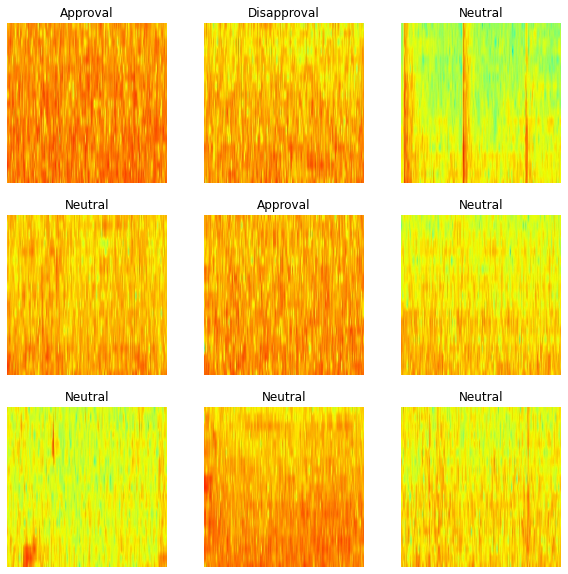

In [8]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843  

In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

32/32 [==============================] - 758s 17s/step - loss: 2.6899 - accuracy: 0.3158


In [22]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
125/125 [==============================] - 2835s 23s/step - loss: 0.9314 - accuracy: 0.6065 - val_loss: 0.7612 - val_accuracy: 0.6613
Epoch 2/10
125/125 [==============================] - 18s 137ms/step - loss: 0.7386 - accuracy: 0.6896 - val_loss: 0.7298 - val_accuracy: 0.6864
Epoch 3/10
125/125 [==============================] - 18s 137ms/step - loss: 0.6941 - accuracy: 0.7102 - val_loss: 0.6383 - val_accuracy: 0.7467
Epoch 4/10
125/125 [==============================] - 18s 136ms/step - loss: 0.6594 - accuracy: 0.7238 - val_loss: 0.6446 - val_accuracy: 0.7528
Epoch 5/10
125/125 [==============================] - 17s 134ms/step - loss: 0.6380 - accuracy: 0.7401 - val_loss: 0.6441 - val_accuracy: 0.7528
Epoch 6/10
125/125 [==============================] - 18s 135ms/step - loss: 0.6249 - accuracy: 0.7479 - val_loss: 0.6112 - val_accuracy: 0.7538
Epoch 7/10
125/125 [==============================] - 18s 135ms/step - loss: 0.6007 - accuracy: 0.7546 - val_loss: 0.6053 - val_ac

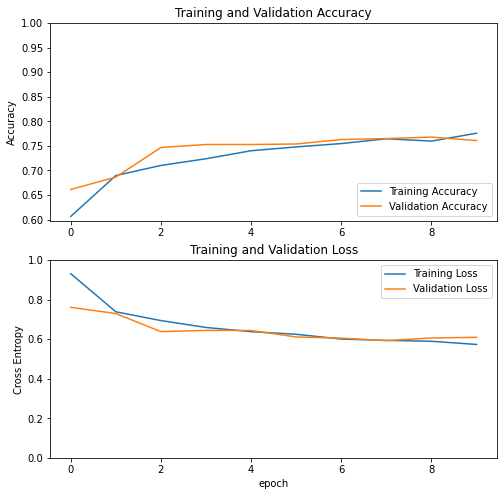

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

37/37 [==============================] - 903s 19s/step - loss: 0.7095 - accuracy: 0.7114
Loss:  0.7095329761505127
Accuracy:  0.711357831954956


In [25]:
"""
                TRAINING           TESTING
        BARK      94.65             93.51
        ERB       82.08             79.64             
        LOG       95.01             93.90
        MEL       76.96             77.43            
"""

'\n                TRAINING           TESTING\n        BARK      94.65             93.51\n        ERB       82.08             79.64             \n        LOG       95.01             93.90\n        MEL       76.96             77.43            \n'

In [26]:
""" v2
        CHANNEL         TRAINING          VALIDATION        TESTING
        BARK              92.19              91.76           86.50              
        ERB               72.07              68.64           62.85
        LOG               76.57              76.48           73.70
        MEL               77.57              76.08           71.13
"""

' v2\n        CHANNEL         TRAINING          VALIDATION        TESTING\n        BARK              92.19              91.76           86.50              \n        ERB               72.07              68.64           62.85\n        LOG               76.57              76.48           73.70\n        MEL               71.13              69.78\n'